# $\Phi$-SO demo

In [70]:
# External packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [71]:
# Internal code import
import physo
import physo.learn.monitoring as monitoring

## Fixing seed

In [72]:
# Seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset

In [73]:
# Source : https://www.theguardian.com/business/2025/apr/03/trumps-tariffs-the-full-list
df_tariffs = pd.read_csv("tariffs.csv",sep=";")
# Source : https://en.wikipedia.org/wiki/United_States_balance_of_trade#cite_note-20
# df_usa_trade_balance = pd.read_csv("usa_trade_balance_a.csv",sep=";")
# Source : https://wits.worldbank.org/CountryProfile/en/Country/USA/Year/2022/TradeFlow/EXPIMP/Partner/all#
# df_usa_trade_balance = pd.read_csv("usa_trade_balance_b.csv",sep=";")
# Source : https://worldpopulationreview.com/country-rankings/us-trade-deficit-by-country (2024)
df_usa_trade_balance = pd.read_csv("usa_trade_balance_c.csv",sep=";")

df = pd.merge(df_tariffs, df_usa_trade_balance, on='territory')

# Remove territories getting flat 10% tariff
# Remove lines where y=10
df = df[df["y"] != 10]
# Remove lines where there is no deficit ie. exports > imports
# df = df[df["exports_from_usa"] < df["imports_to_usa"]]
df["y_target"] = -100*(df["exports_from_usa"]-df["imports_to_usa"])/df["imports_to_usa"]

# Outliers
df["diff"] = np.abs(df["y"] - df["y_target"])/df["y_target"]
df

,territory,usa_tariffs,y,imports_to_usa,exports_from_usa,y_target,diff
0,China,34,67,401.40827,130.987045,67.368125,0.005464
1,Vietnam,46,90,124.80116,11.697848,90.626812,0.006916
2,Taiwan,32,64,106.16842,38.727173,63.522888,0.007511
3,Japan,24,46,135.76128,73.178701,46.097517,0.002115
4,India,26,52,80.12676,38.645962,51.768970,0.004463
5,South Korea,25,50,120.51272,60.296986,49.966289,0.000675
6,Thailand,36,72,57.67016,16.188155,71.929756,0.000977
7,Indonesia,32,64,25.61130,9.236864,63.934419,0.001026
8,Malaysia,24,47,47.66599,25.532903,46.433709,0.012196
9,Cambodia,49,97,11.69876,0.294622,97.481594,0.004940


In [74]:
# Missing territories
# df_tariffs[~df_tariffs["territory"].isin(df_usa_trade_balance["territory"])]

In [75]:
x = df["exports_from_usa"].to_numpy(dtype=float)
m = df["imports_to_usa"].to_numpy(dtype=float)
X = np.stack((x, m))
y = df["y"].to_numpy(dtype=float)

Target function

In [78]:
y_target = df["y_target"].to_numpy(dtype=float)
#y_target = -100*(x-m)/m

# R2 of y vs y_target
from sklearn.metrics import r2_score
r2 = r2_score(y, y_target)
print("R2 = %f"%(r2))
# Reward of y vs y_target
NRMSE = (1/y_target.std())*((y_target - y)**2).mean()**0.5
reward = 1/(1 + NRMSE)
print("Reward = %f"%(reward))

R2 = 0.999623
Reward = 0.980913


Dataset plot

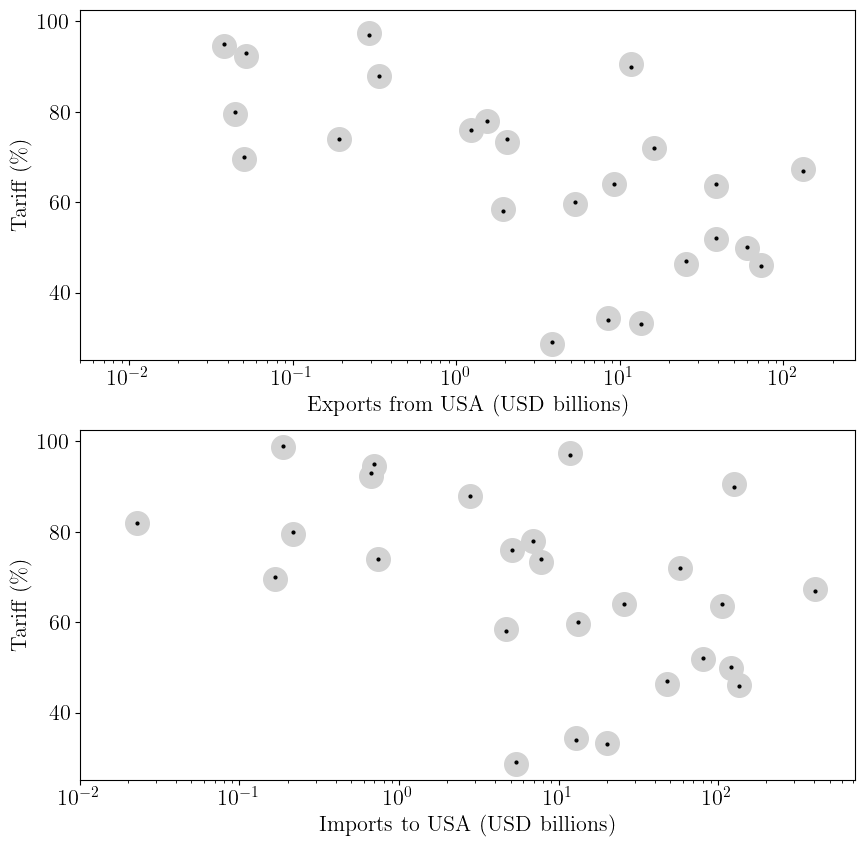

In [79]:
n_dim = X.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,10))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X[i], y_target, 'o', color='lightgray', markersize=17, label="Target")
    curr_ax.plot(X[i], y, 'k.', markersize=4)
    curr_ax.set_xscale('log')
    if i == 0:
        curr_ax.set_xlabel("Exports from USA (USD billions)")
        curr_ax.set_ylabel("Tariff (\\%)")
        curr_ax.set_xlim(0.5*1e-2)
    if i == 1:
        curr_ax.set_xlabel("Imports to USA (USD billions)")
        curr_ax.set_ylabel("Tariff (\\%)")
        curr_ax.set_xlim(1*1e-2)
plt.show()

## Running SR task

### Logging config

In [80]:
save_path_training_curves = 'demo_curves.png'
save_path_log             = 'demo.log'

run_logger     = lambda : monitoring.RunLogger(save_path = save_path_log,
                                                do_save = True)

run_visualiser = lambda : monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run

In [81]:
physo.physym.batch_execute.SHOW_PROGRESS_BAR = True


In [82]:
run_config = physo.config.config0.config0


Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
SR task started...


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/batch_execute.py:81: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:26<00:00, 37.70it/s]


=========== Epoch 00000 ===========
-> Time 1.55 s
-> Memory Usage: 492.02 MB

Overall best  at R=0.977922
-> Raw expression : 
       ⎛    ⎛      x ⎞⎞      
     c⋅⎜m - ⎜-m + ───⎟⎟      
       ⎝    ⎝     1.0⎠⎠      
-c + ────────────────── + 1.0
             m               

Best of epoch at R=0.977922
-> Raw expression : 
       ⎛    ⎛      x ⎞⎞      
     c⋅⎜m - ⎜-m + ───⎟⎟      
       ⎝    ⎝     1.0⎠⎠      
-c + ────────────────── + 1.0
             m               


Physicality
-> 631/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:23<00:00, 42.39it/s]


=========== Epoch 00001 ===========
-> Time 32.26 s
-> Memory Usage: 806.72 MB

Overall best  at R=0.977922
-> Raw expression : 
       ⎛    ⎛      x ⎞⎞      
     c⋅⎜m - ⎜-m + ───⎟⎟      
       ⎝    ⎝     1.0⎠⎠      
-c + ────────────────── + 1.0
             m               

Best of epoch at R=0.773158
-> Raw expression : 
                            0.5
     ⎛            x        ⎞   
 c + ⎜-c + ────────────────⎟   
     ⎜                    2⎟   
     ⎜     ⎛          0.5⎞ ⎟   
     ⎜     ⎜ 0.5 ⎛1.0⎞   ⎟ ⎟   
     ⎜     ⎜m   ⋅⎜───⎟   ⎟ ⎟   
     ⎝     ⎝     ⎝ c ⎠   ⎠ ⎠   
ℯ                              


Physicality
-> 613/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:21<00:00, 45.86it/s]


=========== Epoch 00002 ===========
-> Time 30.06 s
-> Memory Usage: 701.38 MB

Overall best  at R=0.981080
-> Raw expression : 
        ⎛      x      ⎞
        ⎜      ─      ⎟
        ⎜      m      ⎟
(m - x)⋅⎝-c - ℯ  + 1.0⎠
───────────────────────
           m           

Best of epoch at R=0.981080
-> Raw expression : 
        ⎛      x      ⎞
        ⎜      ─      ⎟
        ⎜      m      ⎟
(m - x)⋅⎝-c - ℯ  + 1.0⎠
───────────────────────
           m           


Physicality
-> 612/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:23<00:00, 43.30it/s]


=========== Epoch 00003 ===========
-> Time 29.10 s
-> Memory Usage: 722.39 MB

Overall best  at R=0.981080
-> Raw expression : 
        ⎛      x      ⎞
        ⎜      ─      ⎟
        ⎜      m      ⎟
(m - x)⋅⎝-c - ℯ  + 1.0⎠
───────────────────────
           m           

Best of epoch at R=0.789007
-> Raw expression : 
        ⎛                          2⎞
     0.5⎜⎛          1             ⎞ ⎟
c⋅log   ⎜⎜x⋅──────────────────⋅1.0⎟ ⎟
        ⎝⎝  (m - (-m + m))⋅1.0    ⎠ ⎠


Physicality
-> 610/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:22<00:00, 45.06it/s]


=========== Epoch 00004 ===========
-> Time 29.95 s
-> Memory Usage: 510.59 MB

Overall best  at R=0.981080
-> Raw expression : 
        ⎛      x      ⎞
        ⎜      ─      ⎟
        ⎜      m      ⎟
(m - x)⋅⎝-c - ℯ  + 1.0⎠
───────────────────────
           m           

Best of epoch at R=0.977302
-> Raw expression : 
                             0.5      
                ⎛   2      2⎞         
                ⎜⎛1⎞    ⎛c⎞ ⎟         
-c + c + c + x⋅-⎜⎜─⎟  + ⎜─⎟ ⎟    + 1.0
                ⎝⎝x⎠    ⎝m⎠ ⎠         


Physicality
-> 586/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:20<00:00, 49.22it/s]


=========== Epoch 00005 ===========
-> Time 32.63 s
-> Memory Usage: 707.25 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   


Physicality
-> 597/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:25<00:00, 39.46it/s]


=========== Epoch 00006 ===========
-> Time 37.41 s
-> Memory Usage: 708.59 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.612825
-> Raw expression : 
         1         
───────────────────
            x      
 -c + ─────────────
                  m
      1.0⋅m + x + ─
                  c
ℯ                  


Physicality
-> 580/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:23<00:00, 42.21it/s]


=========== Epoch 00007 ===========
-> Time 32.70 s
-> Memory Usage: 714.27 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.731545
-> Raw expression : 
                1                 
──────────────────────────────────
                                 2
⎛     ⎛             2      ⎞    ⎞ 
⎜     ⎜⎛      1    ⎞       ⎟    ⎟ 
⎜c⋅log⎜⎜x⋅1.0⋅─⋅1.0⎟  + 1.0⎟ + c⎟ 
⎝     ⎝⎝      m    ⎠       ⎠    ⎠ 


Physicality
-> 581/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:21<00:00, 47.48it/s]


=========== Epoch 00008 ===========
-> Time 30.33 s
-> Memory Usage: 506.77 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.593928
-> Raw expression : 
                                      2
⎛ ⎛                        0.5⎞      ⎞ 
⎜ ⎜⎛                     x⎞   ⎟      ⎟ 
⎜ ⎜⎜-c + c - (c + 1.0) + ─⎟   ⎟      ⎟ 
⎜ ⎝⎝                     m⎠   ⎠      ⎟ 
⎝ℯ                              + 1.0⎠ 


Physicality
-> 557/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:20<00:00, 48.78it/s]


=========== Epoch 00009 ===========
-> Time 31.58 s
-> Memory Usage: 696.72 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.654094
-> Raw expression : 
                        2
    ⎛      c      ⎛ x ⎞⎞ 
c + ⎜-c - ℯ  + log⎜───⎟⎟ 
    ⎝             ⎝c⋅m⎠⎠ 


Physicality
-> 574/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:19<00:00, 50.50it/s]


=========== Epoch 00010 ===========
-> Time 28.74 s
-> Memory Usage: 718.17 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.881024
-> Raw expression : 
                       2                  
⎛                    2⎞                   
⎜⎛                 x⎞ ⎟                   
⎜⎜-c - 1.0 + 1.0 + ─⎟ ⎟  - 1.0 + 1.0 + 1.0
⎝⎝                 m⎠ ⎠                   


Physicality
-> 556/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:19<00:00, 52.16it/s]


=========== Epoch 00011 ===========
-> Time 27.48 s
-> Memory Usage: 487.86 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.867783
-> Raw expression : 
                     2
⎛                  2⎞ 
⎜    ⎛  ⎛   c    ⎞⎞ ⎟ 
⎜    ⎜c⋅⎝m⋅ℯ  - x⎠⎟ ⎟ 
⎜c - ⎜────────────⎟ ⎟ 
⎝    ⎝     m      ⎠ ⎠ 


Physicality
-> 551/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:16<00:00, 61.36it/s]


=========== Epoch 00012 ===========
-> Time 23.06 s
-> Memory Usage: 687.55 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.812933
-> Raw expression : 
                       2
              ⎛   1   ⎞ 
1.0 - (c + c)⋅⎜───────⎟ 
              ⎜      x⎟ 
              ⎜1.0 + ─⎟ 
              ⎝      m⎠ 


Physicality
-> 524/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 63.67it/s]


=========== Epoch 00013 ===========
-> Time 21.16 s
-> Memory Usage: 666.25 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.653495
-> Raw expression : 
                                    2
⎛     ⎛   ⎛ c⋅x ⎞            ⎞     ⎞ 
⎜     ⎜log⎜─────⎟ - 1.0      ⎟     ⎟ 
⎜     ⎜   ⎝1.0⋅m⎠            ⎟    c⎟ 
⎜-c - ⎜──────────────── - 1.0⎟ + ℯ ⎟ 
⎝     ⎝      1.0             ⎠     ⎠ 


Physicality
-> 526/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:16<00:00, 60.01it/s]


=========== Epoch 00014 ===========
-> Time 24.10 s
-> Memory Usage: 671.42 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.649820
-> Raw expression : 
       m   
c + ───────
    ⎛m + x⎞
    ⎜─────⎟
    ⎝ 1.0 ⎠
───────────
    c⋅c    


Physicality
-> 504/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:16<00:00, 58.83it/s]


=========== Epoch 00015 ===========
-> Time 24.55 s
-> Memory Usage: 526.58 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.746981
-> Raw expression : 
  c      x
────── + ─
⎛  x ⎞   x
⎜  ─ ⎟    
⎜  m ⎟    
⎜-ℯ  ⎟    
⎜────⎟    
⎝1.0 ⎠    


Physicality
-> 530/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 66.51it/s]


=========== Epoch 00016 ===========
-> Time 22.09 s
-> Memory Usage: 714.59 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.869559
-> Raw expression : 
              1               
──────────────────────────────
      0.5 ⎛                 x⎞
     c   ⋅⎜-(c + c - 1.0) + ─⎟
          ⎝                 m⎠
1.0⋅ℯ                         


Physicality
-> 499/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 71.01it/s]


=========== Epoch 00017 ===========
-> Time 19.36 s
-> Memory Usage: 698.53 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.968276
-> Raw expression : 
       c           x
-c + ───── + 1.0 + ─
     ⎛1.0⎞         m
     ⎜───⎟          
     ⎜⎛x⎞⎟          
     ⎜⎜─⎟⎟          
     ⎝⎝m⎠⎠          


Physicality
-> 480/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 74.18it/s]


=========== Epoch 00018 ===========
-> Time 19.91 s
-> Memory Usage: 484.36 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.740579
-> Raw expression : 
          2
⎛   x   1⎞ 
⎜ - ─ + ─⎟ 
⎜   m   c⎟ 
⎝ℯ       ⎠ 
───────────
    1.0    


Physicality
-> 487/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 74.05it/s]


=========== Epoch 00019 ===========
-> Time 20.75 s
-> Memory Usage: 734.45 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.554606
-> Raw expression : 
                               2
⎛          ⎛            1⎞    ⎞ 
⎜      c - ⎜c - x⋅c⋅1.0⋅─⎟⋅1.0⎟ 
⎜          ⎝            m⎠    ⎟ 
⎝-c + ℯ                       ⎠ 


Physicality
-> 473/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:11<00:00, 86.96it/s]


=========== Epoch 00020 ===========
-> Time 17.71 s
-> Memory Usage: 675.39 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.977922
-> Raw expression : 
         1    
-c + ─────────
     ⎛   m   ⎞
     ⎜───────⎟
     ⎝c⋅x + m⎠


Physicality
-> 474/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:12<00:00, 80.38it/s]


=========== Epoch 00021 ===========
-> Time 20.10 s
-> Memory Usage: 492.31 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.982567
-> Raw expression : 
  ⎛   m⋅m     ⎞
c⋅⎜- ───── + x⎟
  ⎝  1.0⋅m    ⎠
───────────────
       m       


Physicality
-> 475/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:11<00:00, 88.31it/s]


=========== Epoch 00022 ===========
-> Time 20.25 s
-> Memory Usage: 657.14 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.677084
-> Raw expression : 
     1     
───────────
⎛c⋅(m + x)⎞
⎜─────────⎟
⎝    m    ⎠


Physicality
-> 488/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:11<00:00, 89.60it/s]


=========== Epoch 00023 ===========
-> Time 17.74 s
-> Memory Usage: 714.69 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.783000
-> Raw expression : 
                         2
⎛        m              ⎞ 
⎜ -c + ─────            ⎟ 
⎜      m + x          x ⎟ 
⎜ℯ           - 1.0 + ───⎟ 
⎝                    c⋅x⎠ 


Physicality
-> 448/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:12<00:00, 82.37it/s]


=========== Epoch 00024 ===========
-> Time 19.50 s
-> Memory Usage: 452.56 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.742457
-> Raw expression : 
                              1  
 -c + c + 1.0 + 1.0 + 1.0 + ─────
                                x
                            c + ─
                                m
ℯ                                


Physicality
-> 510/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:12<00:00, 78.63it/s]


=========== Epoch 00025 ===========
-> Time 18.97 s
-> Memory Usage: 752.53 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.982567
-> Raw expression : 
c⋅c⋅(m - x)
───────────
     m     


Physicality
-> 528/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 63.33it/s]


=========== Epoch 00026 ===========
-> Time 26.93 s
-> Memory Usage: 490.72 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.982567
-> Raw expression : 
  ⎛     m        x⎞
c⋅⎜─────────── - ─⎟
  ⎜⎛   m     ⎞   m⎟
  ⎜⎜- ─── + m⎟    ⎟
  ⎜⎜  1.0    ⎟    ⎟
  ⎜⎜─────────⎟    ⎟
  ⎝⎝   1.0   ⎠    ⎠


Physicality
-> 551/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:11<00:00, 84.79it/s]


=========== Epoch 00027 ===========
-> Time 20.77 s
-> Memory Usage: 736.86 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.847869
-> Raw expression : 
                  -m + x
              c - ──────
                    m   
-(c + c⋅c) + ℯ          


Physicality
-> 552/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:12<00:00, 79.10it/s]


=========== Epoch 00028 ===========
-> Time 20.60 s
-> Memory Usage: 729.41 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.946267
-> Raw expression : 
           ⎛    ⎛    m + m + x + x⎞⎞
         c⋅⎜x - ⎜m + ─────────────⎟⎟
           ⎝    ⎝          c      ⎠⎠
-c + c + ───────────────────────────
                      m             


Physicality
-> 568/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 68.14it/s]


=========== Epoch 00029 ===========
-> Time 23.26 s
-> Memory Usage: 497.50 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.751946
-> Raw expression : 
     m - x
 c + ─────
       m  
ℯ         


Physicality
-> 611/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 70.33it/s]


=========== Epoch 00030 ===========
-> Time 22.43 s
-> Memory Usage: 686.44 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.816397
-> Raw expression : 
             2
⎛    ⎛    m⎞⎞ 
⎜x - ⎜m - ─⎟⎟ 
⎜    ⎝    c⎠⎟ 
⎜───────────⎟ 
⎝   m + x   ⎠ 


Physicality
-> 624/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 67.46it/s]


=========== Epoch 00031 ===========
-> Time 24.50 s
-> Memory Usage: 727.77 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.751946
-> Raw expression : 
   ⎛    m + x⎞
 m⋅⎜c + ─────⎟
   ⎝      m  ⎠
 ─────────────
   -m - m + m 
ℯ             


Physicality
-> 636/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:16<00:00, 60.92it/s]


=========== Epoch 00032 ===========
-> Time 23.46 s
-> Memory Usage: 484.03 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.879879
-> Raw expression : 
                 m - x
             x + ─────
                   c  
    -x + x + ─────────
                 c    
c + ──────────────────
            m         


Physicality
-> 644/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 65.59it/s]


=========== Epoch 00033 ===========
-> Time 22.92 s
-> Memory Usage: 706.47 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.885500
-> Raw expression : 
                            2
⎛                         2⎞ 
⎜⎛              x        ⎞ ⎟ 
⎜⎜c + c + c - ───── + 1.0⎟ ⎟ 
⎜⎜            ⎛ m ⎞      ⎟ ⎟ 
⎜⎜            ⎜───⎟      ⎟ ⎟ 
⎝⎝            ⎝1.0⎠      ⎠ ⎠ 


Physicality
-> 677/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:16<00:00, 58.83it/s]


=========== Epoch 00034 ===========
-> Time 26.80 s
-> Memory Usage: 520.89 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.982567
-> Raw expression : 
c⋅(-m + m + x)    
────────────── + c
  -m - x + x      


Physicality
-> 684/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:17<00:00, 58.61it/s]


=========== Epoch 00035 ===========
-> Time 24.02 s
-> Memory Usage: 733.30 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.982567
-> Raw expression : 
        ⎛                ⎛    c⋅x⎞⎞
c + c - ⎜c + c + c + c - ⎜c + ───⎟⎟
        ⎝                ⎝     m ⎠⎠


Physicality
-> 677/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:18<00:00, 54.63it/s]


=========== Epoch 00036 ===========
-> Time 25.29 s
-> Memory Usage: 730.92 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.773468
-> Raw expression : 
                              2
⎛                 m          ⎞ 
⎜ c + c + c + ───────── - 1.0⎟ 
⎜             c              ⎟ 
⎜             ─⋅(m + x)      ⎟ 
⎜             c              ⎟ 
⎝ℯ                           ⎠ 


Physicality
-> 740/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 66.08it/s]


=========== Epoch 00037 ===========
-> Time 21.50 s
-> Memory Usage: 541.39 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.757597
-> Raw expression : 
                               2      
                 ⎛        x   ⎞       
-c + c + c + c + ⎜-c + ───────⎟  - 1.0
                 ⎜     ⎛m + x⎞⎟       
                 ⎜     ⎜─────⎟⎟       
                 ⎝     ⎝  c  ⎠⎠       


Physicality
-> 704/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 67.76it/s]


=========== Epoch 00038 ===========
-> Time 23.05 s
-> Memory Usage: 745.94 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.957130
-> Raw expression : 
                       ⎛    ⎛    m - x⎞⎞
               x + x - ⎜m - ⎜x + ─────⎟⎟
                       ⎝    ⎝      c  ⎠⎠
-c + c + 1.0 + ─────────────────────────
                           m            


Physicality
-> 752/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:12<00:00, 80.51it/s]


=========== Epoch 00039 ===========
-> Time 18.53 s
-> Memory Usage: 540.16 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.978002
-> Raw expression : 
  ⎛                   x            ⎞
c⋅⎜m - x + ────────────────────────⎟
  ⎝        -c - c + c + c + c + 1.0⎠
────────────────────────────────────
                 m                  


Physicality
-> 743/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 65.95it/s]


=========== Epoch 00040 ===========
-> Time 22.23 s
-> Memory Usage: 738.73 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.982567
-> Raw expression : 
     c⋅(m - x)      
────────────────────
-m + m - x - (m - x)


Physicality
-> 776/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:12<00:00, 81.51it/s]


=========== Epoch 00041 ===========
-> Time 18.79 s
-> Memory Usage: 760.20 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.818022
-> Raw expression : 
             c             
 ──────────────────────────
 ⎛-m + m - (m + m + m + x)⎞
 ⎜────────────────────────⎟
 ⎝           m            ⎠
ℯ                          


Physicality
-> 757/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:11<00:00, 87.81it/s]


=========== Epoch 00042 ===========
-> Time 18.28 s
-> Memory Usage: 793.25 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.776658
-> Raw expression : 
    ⎛             ⎛     m + x + x⎞      ⎞
    ⎜         c - ⎜-c + ─────────⎟      ⎟
    ⎜             ⎝         m    ⎠      ⎟
1.0⋅⎝c + c + ℯ                     - 1.0⎠


Physicality
-> 785/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 75.05it/s] 


=========== Epoch 00043 ===========
-> Time 21.18 s
-> Memory Usage: 697.75 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.786027
-> Raw expression : 
                               2
⎛                m     m      ⎞ 
⎜     -c + c + ───── + ─      ⎟ 
⎜              m + x   m      ⎟ 
⎜ c + ──────────────────      ⎟ 
⎜            1.0              ⎟ 
⎝ℯ                       - 1.0⎠ 


Physicality
-> 767/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:10<00:00, 98.96it/s]


=========== Epoch 00044 ===========
-> Time 16.13 s
-> Memory Usage: 713.19 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.957130
-> Raw expression : 
  ⎛              x⎞          
  ⎜       -1.0 + ─⎟          
  ⎜              m⎟         x
- ⎜-1.0 + ────────⎟ + 1.0 + ─
  ⎝        1.0⋅c  ⎠         m


Physicality
-> 784/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:12<00:00, 82.19it/s]


=========== Epoch 00045 ===========
-> Time 21.28 s
-> Memory Usage: 753.86 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.872637
-> Raw expression : 
                                  2
⎛          ⎛                   x⎞⎞ 
⎜          ⎜           c + c + ─⎟⎟ 
⎜          ⎜                   m⎟⎟ 
⎜      c - ⎜-c - 1.0 + ─────────⎟⎟ 
⎜          ⎝               c    ⎠⎟ 
⎝-c + ℯ                          ⎠ 


Physicality
-> 780/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 66.39it/s]


=========== Epoch 00046 ===========
-> Time 21.18 s
-> Memory Usage: 523.11 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.807355
-> Raw expression : 
                                       2
     ⎛              x                 ⎞ 
     ⎜      c + ──────────            ⎟ 
     ⎜          -m - m + x            ⎟ 
-c + ⎝-c + ℯ               - 1.0 + 1.0⎠ 


Physicality
-> 822/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 75.59it/s]


=========== Epoch 00047 ===========
-> Time 22.08 s
-> Memory Usage: 472.00 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.924943
-> Raw expression : 
         m   
 -c - ───────
       m     
      ─── - x
      ⎛x⎞    
      ⎜─⎟    
      ⎝m⎠    
ℯ            


Physicality
-> 825/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 66.97it/s]


=========== Epoch 00048 ===========
-> Time 24.13 s
-> Memory Usage: 745.47 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.862291
-> Raw expression : 
                                 1.0         
 -c - c - c - c - 1.0 + ─────────────────────
                          ⎛    ⎛          x⎞⎞
                        c⋅⎜c - ⎜c - 1.0 + ─⎟⎟
                          ⎝    ⎝          m⎠⎠
ℯ                                            


Physicality
-> 809/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 66.74it/s]


=========== Epoch 00049 ===========
-> Time 23.14 s
-> Memory Usage: 454.42 MB

Overall best  at R=0.982567
-> Raw expression : 
                          0.5
     c⋅x               ⎛1⎞   
-c + ─── - (1.0 - 1.0)⋅⎜─⎟   
      m                ⎝c⎠   

Best of epoch at R=0.801453
-> Raw expression : 
                                x                  
                            c + ─                  
                                m                  
 -c - c - c - c + c + 1.0 + ─────                  
                              c                    
ℯ                                 - 1.0 + 1.0 + 1.0


Physicality
-> 813/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 62.94it/s]


=========== Epoch 00050 ===========
-> Time 23.58 s
-> Memory Usage: 747.67 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠


Physicality
-> 857/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 63.90it/s]


=========== Epoch 00051 ===========
-> Time 20.85 s
-> Memory Usage: 541.73 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.869345
-> Raw expression : 
     ⎛                     m + x + x⎞
 c - ⎜-c - c - c - c + c + ─────────⎟
     ⎝                        c⋅m   ⎠
ℯ                                    


Physicality
-> 863/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 66.04it/s]


=========== Epoch 00052 ===========
-> Time 22.42 s
-> Memory Usage: 741.92 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.879768
-> Raw expression : 
            c       
           ℯ        
c + ────────────────
     m + x + x      
     ─────────      
         m          
    ℯ          + 1.0


Physicality
-> 876/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 71.14it/s]


=========== Epoch 00053 ===========
-> Time 20.24 s
-> Memory Usage: 522.36 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.957130
-> Raw expression : 
                  -m + m + m - x - x
c + c + c + 1.0 + ──────────────────
                          m         
────────────────────────────────────
                 c                  


Physicality
-> 845/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 65.03it/s]


=========== Epoch 00054 ===========
-> Time 21.36 s
-> Memory Usage: 740.80 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.863420
-> Raw expression : 
             ⎛     m - x⎞
         x - ⎜-m + ─────⎟
             ⎝       c  ⎠
 c + c - ────────────────
                m        
ℯ                        


Physicality
-> 861/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 65.45it/s]


=========== Epoch 00055 ===========
-> Time 21.63 s
-> Memory Usage: 725.84 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.937771
-> Raw expression : 
 ⎛                                 2⎞
 ⎜⎛                     m         ⎞ ⎟
 ⎜⎜-c + c + c + ──────────────────⎟ ⎟
 ⎝⎝             -m - m - m + m + x⎠ ⎠
ℯ                                    


Physicality
-> 844/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:16<00:00, 62.17it/s]


=========== Epoch 00056 ===========
-> Time 22.63 s
-> Memory Usage: 484.08 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.982567
-> Raw expression : 
   c    
────────
⎛  m   ⎞
⎜──────⎟
⎝-m + x⎠


Physicality
-> 900/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 71.85it/s] 


=========== Epoch 00057 ===========
-> Time 20.85 s
-> Memory Usage: 741.86 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.811960
-> Raw expression : 
                             x        
 -c - c - c + c + c + ────────────────
                                x     
                      -m + ───────────
                           c - (c + c)
ℯ                                     


Physicality
-> 898/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 68.86it/s]


=========== Epoch 00058 ===========
-> Time 20.86 s
-> Memory Usage: 490.72 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.805662
-> Raw expression : 
                                x
                            c + ─
                                m
 -c - c - c - c + c + 1.0 + ─────
                              c  
ℯ                                


Physicality
-> 884/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 64.03it/s]


=========== Epoch 00059 ===========
-> Time 22.52 s
-> Memory Usage: 752.98 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.877732
-> Raw expression : 
         m + x    
 c + ─────────────
         ⎛     m ⎞
     x - ⎜m + ───⎟
         ⎜    ⎛x⎞⎟
         ⎜    ⎜─⎟⎟
         ⎝    ⎝m⎠⎠
ℯ                 


Physicality
-> 871/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 64.56it/s]


=========== Epoch 00060 ===========
-> Time 22.23 s
-> Memory Usage: 534.11 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.817115
-> Raw expression : 
                  m        
      c - ─────────────────
          m + m - x + x + x
      ─────────────────────
                c          
-c + ℯ                     


Physicality
-> 898/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 68.94it/s]


=========== Epoch 00061 ===========
-> Time 21.30 s
-> Memory Usage: 745.33 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.853985
-> Raw expression : 
                             x                 
          -c - c + ────────────────────── + 1.0
                   (c - (-c + c))⋅(m - x)      
-c + c + ℯ                                     


Physicality
-> 891/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 66.84it/s]


=========== Epoch 00062 ===========
-> Time 22.08 s
-> Memory Usage: 514.12 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.783472
-> Raw expression : 
                             x
                         c + ─
                     m       m
 c + c + c + c + c + ─ - ─────
                     m     c  
ℯ                             


Physicality
-> 908/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 72.12it/s]


=========== Epoch 00063 ===========
-> Time 20.36 s
-> Memory Usage: 739.06 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.832839
-> Raw expression : 
                                            2
⎛                              x           ⎞ 
⎜ -c - c + c + 1.0 + ──────────────────────⎟ 
⎜                      ⎛                 m⎞⎟ 
⎜                    m⋅⎜-c + c + c + c + ─⎟⎟ 
⎜                      ⎝                 m⎠⎟ 
⎝ℯ                                         ⎠ 


Physicality
-> 914/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 66.22it/s]


=========== Epoch 00064 ===========
-> Time 21.22 s
-> Memory Usage: 499.17 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.925760
-> Raw expression : 
                             x           
 -c + c + c + c + ───────────────────────
                             m           
                  -m + ────────────── + x
                       -c - c - c + c    
ℯ                                        


Physicality
-> 927/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:20<00:00, 49.57it/s]


=========== Epoch 00065 ===========
-> Time 28.78 s
-> Memory Usage: 745.62 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.773468
-> Raw expression : 
                          m - x
 -c + c + c + c + c + c + ─────
                          m + x
ℯ                              


Physicality
-> 913/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:19<00:00, 52.34it/s]


=========== Epoch 00066 ===========
-> Time 26.31 s
-> Memory Usage: 527.38 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.870835
-> Raw expression : 
                    x         
   c + c + ───────────────────
               x - (m + m + m)
           x + ───────────────
                      c       
c⋅ℯ                           


Physicality
-> 900/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:18<00:00, 54.28it/s]


=========== Epoch 00067 ===========
-> Time 29.43 s
-> Memory Usage: 557.88 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.924915
-> Raw expression : 
                    x               
 c + ───────────────────────────────
                              x     
     -m - m + m - x + x + ──────────
                                   m
                          -c + c + ─
                                   x
ℯ                                   


Physicality
-> 899/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:19<00:00, 52.08it/s]


=========== Epoch 00068 ===========
-> Time 28.83 s
-> Memory Usage: 538.39 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.832283
-> Raw expression : 
                                m    
 -c - c - c - c - c - 1.0 + ─────────
                              ⎛    x⎞
                            c⋅⎜m + ─⎟
                              ⎝    c⎠
ℯ                                    


Physicality
-> 898/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:22<00:00, 44.52it/s]


=========== Epoch 00069 ===========
-> Time 32.92 s
-> Memory Usage: 613.05 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.929904
-> Raw expression : 
                            x       
              -m + m + x + ───      
                           ⎛m⎞      
                           ⎜─⎟      
                           ⎝x⎠      
 -c - c - c - ────────────────      
                     m              
ℯ                              - 1.0


Physicality
-> 884/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:21<00:00, 47.12it/s]


=========== Epoch 00070 ===========
-> Time 31.07 s
-> Memory Usage: 534.16 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.847448
-> Raw expression : 
                           m - (-m + x)
                           ────────────
                                m      
         -c - (c + 1.0) + ℯ            
-c + c + ──────────────────────────────
                       c               


Physicality
-> 920/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:22<00:00, 44.23it/s]


=========== Epoch 00071 ===========
-> Time 35.47 s
-> Memory Usage: 657.73 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.856290
-> Raw expression : 
             x + x            
 c + c + c - ─────            
              c⋅m             
ℯ                  - 1.0 - 1.0


Physicality
-> 930/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:23<00:00, 42.32it/s]


=========== Epoch 00072 ===========
-> Time 31.74 s
-> Memory Usage: 746.36 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.850892
-> Raw expression : 
                   m      ⎛    x⎞            
         c + c + ────── - ⎜c + ─⎟ - 1.0 + 1.0
                 -m + x   ⎝    x⎠            
c + c + ℯ                                    


Physicality
-> 944/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 68.21it/s]


=========== Epoch 00073 ===========
-> Time 22.23 s
-> Memory Usage: 540.48 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.770206
-> Raw expression : 
                      ⎛     x⎞   x
              c + c - ⎜-c + ─⎟ + ─
                      ⎝     m⎠   x
-c - c - c + ℯ                    


Physicality
-> 955/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


=========== Epoch 00074 ===========
-> Time 23.78 s
-> Memory Usage: 687.31 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.821630
-> Raw expression : 
                        x       
 -c - c - c + c + ──────────────
                  -m - m + x + x
ℯ                               


Physicality
-> 957/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:17<00:00, 56.45it/s]


=========== Epoch 00075 ===========
-> Time 25.67 s
-> Memory Usage: 556.12 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.860726
-> Raw expression : 
      ⎛        x        c⎞
1.0 - ⎜c + ───────── + ℯ ⎟
      ⎜    ⎛   m   ⎞     ⎟
      ⎜    ⎜───────⎟     ⎟
      ⎜    ⎜      x⎟     ⎟
      ⎜    ⎜      ─⎟     ⎟
      ⎜    ⎜      x⎟     ⎟
      ⎝    ⎝-c + ℯ ⎠     ⎠


Physicality
-> 926/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:20<00:00, 48.24it/s]


=========== Epoch 00076 ===========
-> Time 27.39 s
-> Memory Usage: 759.39 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.845563
-> Raw expression : 
                   x - (m + m)
        -c - 1.0 + ───────────
                        m     
 -2⋅c - ──────────────────────
                  c           
ℯ                             


Physicality
-> 927/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:17<00:00, 57.45it/s]


=========== Epoch 00077 ===========
-> Time 24.27 s
-> Memory Usage: 549.72 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.821630
-> Raw expression : 
                    m                       
 -c - c + ────────────────────── - 1.0 + 1.0
          -m - m - x + x + x + x            
ℯ                                           


Physicality
-> 889/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:18<00:00, 54.44it/s]


=========== Epoch 00078 ===========
-> Time 25.30 s
-> Memory Usage: 695.41 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.854556
-> Raw expression : 
                                          m - x
                   -c + c + c + c + 1.0 + ─────
                                            m  
      -1.0 + 1.0 + ────────────────────────────
                                c              
-c + ℯ                                         


Physicality
-> 885/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:20<00:00, 49.62it/s]


=========== Epoch 00079 ===========
-> Time 27.51 s
-> Memory Usage: 544.05 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.928847
-> Raw expression : 
          ⎛ ⎛        x    ⎞ ⎞
          ⎜-⎜-x + ────────⎟ ⎟
          ⎜ ⎜            x⎟ ⎟
          ⎜ ⎜     -1.0 + ─⎟ ⎟
          ⎜ ⎝            m⎠ ⎟
          ⎜─────────────────⎟
          ⎝        m        ⎠
 -c - c + ───────────────────
                   c         
ℯ                            


Physicality
-> 905/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:16<00:00, 61.08it/s]


=========== Epoch 00080 ===========
-> Time 23.24 s
-> Memory Usage: 529.14 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.821630
-> Raw expression : 
                    x              
 -c + ─────────────────────────────
              ⎛        ⎛   m     ⎞⎞
      x + x - ⎜m + x - ⎜- ─── + x⎟⎟
              ⎜        ⎜  ⎛m⎞    ⎟⎟
              ⎜        ⎜  ⎜─⎟    ⎟⎟
              ⎝        ⎝  ⎝m⎠    ⎠⎠
ℯ                                  


Physicality
-> 868/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


=========== Epoch 00081 ===========
-> Time 22.92 s
-> Memory Usage: 779.84 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.895350
-> Raw expression : 
                               m    
              -c - c + c + ─────────
                              m     
                           - ─── + x
                             1.0    
-c - c - c + ℯ                      


Physicality
-> 874/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 63.39it/s]


=========== Epoch 00082 ===========
-> Time 21.87 s
-> Memory Usage: 524.72 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.868432
-> Raw expression : 
                    x     x      
 -c - c - c + c - ───── - ─ + 1.0
                  m + m   m      
ℯ                                


Physicality
-> 873/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 63.49it/s]


=========== Epoch 00083 ===========
-> Time 21.39 s
-> Memory Usage: 745.23 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.851672
-> Raw expression : 
              x + x + 0      
 -c - c - c + ─────────      
                 c⋅m         
ℯ                       - 1.0


Physicality
-> 916/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:16<00:00, 60.96it/s]


=========== Epoch 00084 ===========
-> Time 26.88 s
-> Memory Usage: 557.48 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.865198
-> Raw expression : 
                  ⎛    m        ⎞
              m - ⎜───────── - x⎟
                  ⎝c + c + c    ⎠
          x - ───────────────────
                       c         
 -c - c - ───────────────────────
                     m           
ℯ                                


Physicality
-> 944/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 67.95it/s]


=========== Epoch 00085 ===========
-> Time 21.00 s
-> Memory Usage: 596.19 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.797460
-> Raw expression : 
  ⎛        m + m⎞ 
 -⎜m + x - ─────⎟ 
  ⎝          c  ⎠ 
 ─────────────────
        c⋅m       
ℯ                 


Physicality
-> 950/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 73.02it/s]


=========== Epoch 00086 ===========
-> Time 18.83 s
-> Memory Usage: 569.33 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.770206
-> Raw expression : 
                x   m - x
      c - 1.0 + ─ + ─────
                x     m  
-c + ℯ                   


Physicality
-> 965/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 75.23it/s]


=========== Epoch 00087 ===========
-> Time 21.91 s
-> Memory Usage: 734.38 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.943574
-> Raw expression : 
                           x             
 -c - c + -c - ──────────────────────────
                             x           
               m - ──────────────────────
                   -c - c + c - 1.0 + 1.0
ℯ                                        


Physicality
-> 970/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:12<00:00, 79.50it/s]


=========== Epoch 00088 ===========
-> Time 22.16 s
-> Memory Usage: 534.23 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.821630
-> Raw expression : 
             x      
 3⋅c - ─────────────
       m + m - x - x
ℯ                   


Physicality
-> 963/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 67.71it/s]


=========== Epoch 00089 ===========
-> Time 23.50 s
-> Memory Usage: 749.58 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.775471
-> Raw expression : 
          ⎛- -x ⎞
          ⎜─────⎟
          ⎝  m  ⎠
      c - ───────
            1.0  
-c + ℯ           


Physicality
-> 987/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 73.99it/s]


=========== Epoch 00090 ===========
-> Time 20.10 s
-> Memory Usage: 519.97 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.844655
-> Raw expression : 
                  -m + m - x
              c + ──────────
                    m - x   
 -c - c - c - ──────────────
                    c       
ℯ                           


Physicality
-> 975/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 70.92it/s]


=========== Epoch 00091 ===========
-> Time 21.99 s
-> Memory Usage: 757.58 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.806606
-> Raw expression : 
                       2
⎛       -2⋅m + x      ⎞ 
⎜   c - ────────      ⎟ 
⎜          m          ⎟ 
⎝- ℯ             - 1.0⎠ 


Physicality
-> 972/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 64.90it/s]


=========== Epoch 00092 ===========
-> Time 22.02 s
-> Memory Usage: 539.47 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.851632
-> Raw expression : 
                         2
⎛                x      ⎞ 
⎜      -c + -c - ─      ⎟ 
⎜                m      ⎟ 
⎝-c + ℯ            + 1.0⎠ 


Physicality
-> 973/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 65.36it/s]


=========== Epoch 00093 ===========
-> Time 22.32 s
-> Memory Usage: 755.52 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.851957
-> Raw expression : 
                         2
⎛                      x⎞ 
⎜          3⋅c - 1.0 - ─⎟ 
⎜                      m⎟ 
⎜         ℯ             ⎟ 
⎜-c - c - ──────────────⎟ 
⎝               c       ⎠ 


Physicality
-> 970/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 65.61it/s]


=========== Epoch 00094 ===========
-> Time 20.77 s
-> Memory Usage: 520.73 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.775471
-> Raw expression : 
                -m + m - x
          2⋅c + ──────────
                    m     
-c - c + ℯ                


Physicality
-> 968/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 65.81it/s]


=========== Epoch 00095 ===========
-> Time 20.26 s
-> Memory Usage: 765.73 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.861968
-> Raw expression : 
      -m + m + x
 -c + ──────────
      ⎛m - -2⋅m⎞
      ⎜────────⎟
      ⎝   c    ⎠
ℯ               


Physicality
-> 951/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:14<00:00, 68.68it/s]


=========== Epoch 00096 ===========
-> Time 20.95 s
-> Memory Usage: 558.09 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.863287
-> Raw expression : 
                                x        
            m + m - x + ─────────────────
                                        m
                        c - 1.0 + 1.0 + ─
                                        m
 -c - 1.0 + ─────────────────────────────
                          m              
ℯ                                        


Physicality
-> 959/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 63.67it/s]


=========== Epoch 00097 ===========
-> Time 21.92 s
-> Memory Usage: 737.83 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.823804
-> Raw expression : 
  2           x        x
 c  + c + ────────── - ─
          -m - x - x   m
ℯ                       


Physicality
-> 954/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:15<00:00, 64.82it/s]


=========== Epoch 00098 ===========
-> Time 24.51 s
-> Memory Usage: 541.69 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.756963
-> Raw expression : 
             x      
 3⋅c - 1.0 - ─      
             m      
ℯ              - 1.0


Physicality
-> 945/1000 physical


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
100%|██████████| 1000/1000 [00:13<00:00, 72.95it/s]


=========== Epoch 00099 ===========
-> Time 19.64 s
-> Memory Usage: 769.31 MB

Overall best  at R=0.982567
-> Raw expression : 
  ⎛                             x      ⎞
  ⎜       -m + m - x + x + ────────────⎟
  ⎜                         c + c      ⎟
  ⎜                        ℯ      + 1.0⎟
c⋅⎜-1.0 + ─────────────────────────────⎟
  ⎝                     m              ⎠

Best of epoch at R=0.812124
-> Raw expression : 
           m + x + x   x
 -c + -c - ───────── - ─
             m + x     m
ℯ                       


Physicality
-> 956/1000 physical


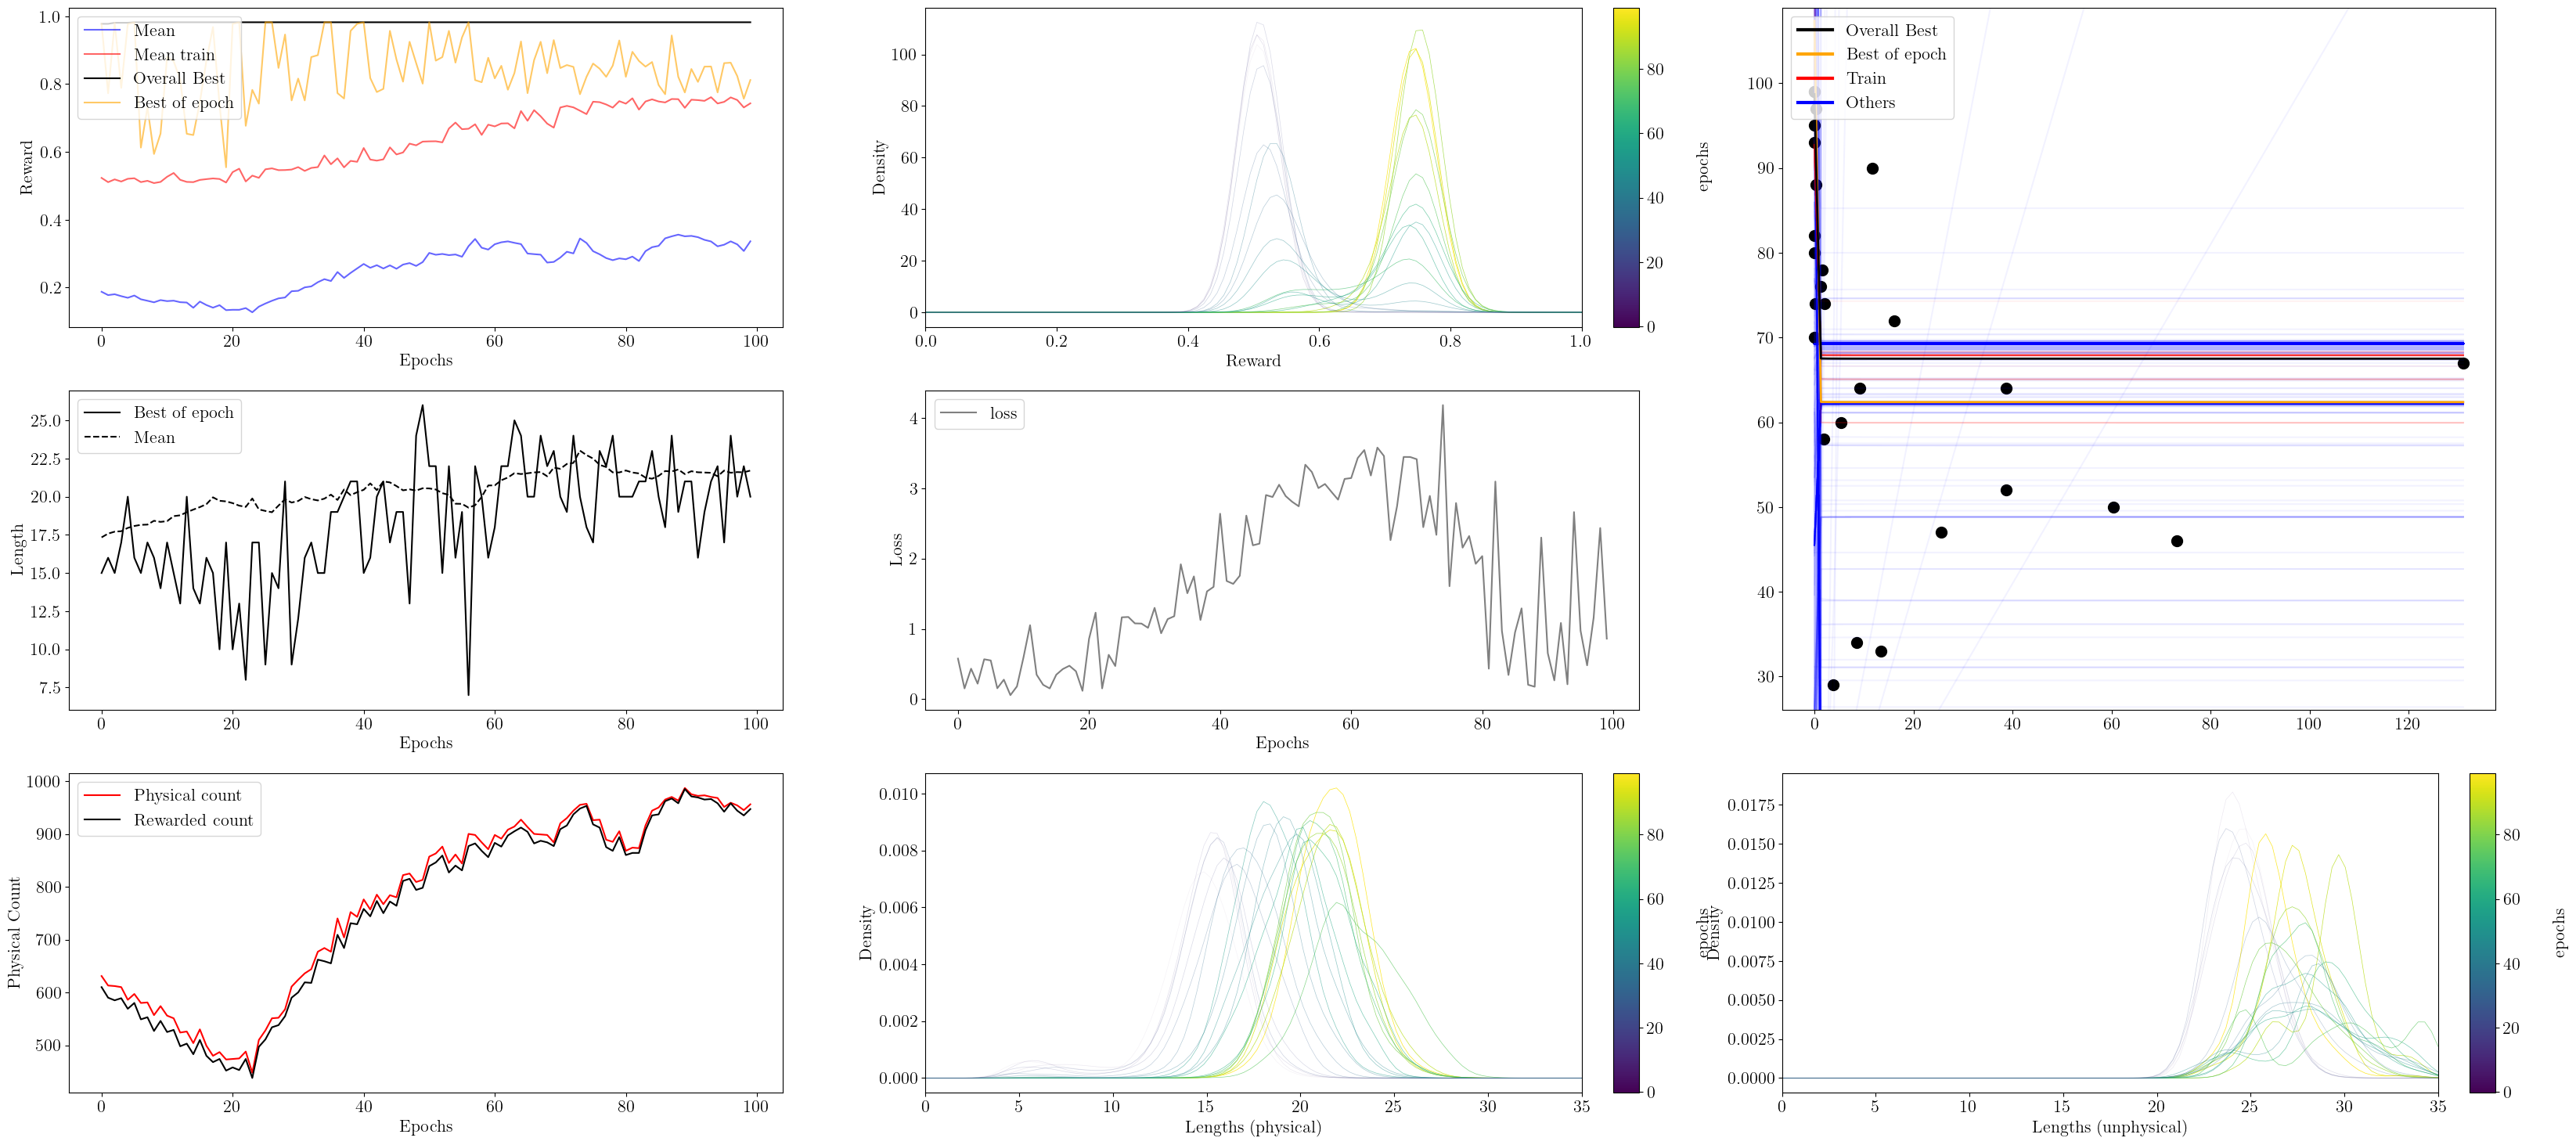

In [83]:
# Running SR task
expression, logs = physo.SR(X, y,
                            # Giving names of variables (for display purposes)
                            X_names = [ "x", "m" ],
                            # Associated physical units (ignore or pass zeroes if irrelevant)
                            X_units = [ [1, 0], [1, 0] ], # USD billions
                            # Giving name of root variable (for display purposes)
                            y_name  = "y",
                            y_units = [0, 0,], # Dimensionsless ratio
                            # Fixed constants
                            fixed_consts       = [ 1.     ],
                            fixed_consts_units = [ [0,0,] ],
                            # Free constants names (for display purposes)
                            free_consts_names = [ "c"     , ],
                            free_consts_units = [ [0, 0,] , ],
                            # Symbolic operations that can be used to make f
                            op_names = ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "neg", "exp", "log",],
                            get_run_logger     = run_logger,
                            get_run_visualiser = run_visualiser,
                            # Run config
                            run_config = run_config,
                            # Parallel mode (only available when running from python scripts, not notebooks)
                            parallel_mode = False,
                            # Number of iterations
                            epochs = 100
)

## Inspecting best expression found

In [86]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = logs.get_pareto_front()

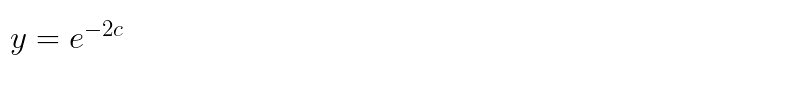

c = -2.119196


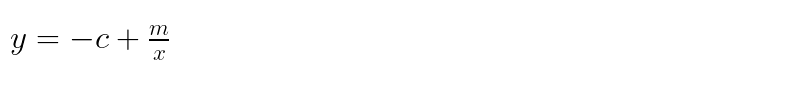

c = -60.901569


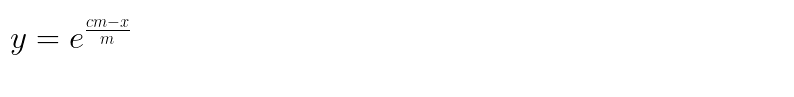

c = 4.544589


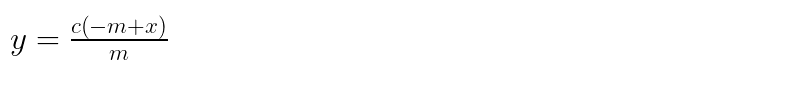

c = -100.199061


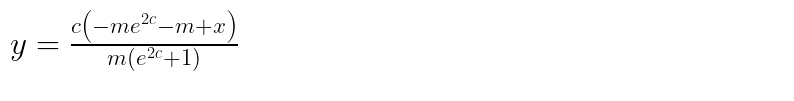

c = -100.199061


In [87]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    free_consts = prog.free_consts.class_values[0].detach().cpu().numpy()
    for i in range (len(free_consts)):
        print("%s = %f"%(prog.library.free_const_names[i], free_consts[i]))